# Построение модели определения стоимости автомобиля

**Данные:** технические характеристики, комплектации и цены автомобилей. 

**Задача:** нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#импорт библиотек
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Взглянем на общую информацию.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Уже сейчас можно увидеть аномальные значения.

Удалим признаки, ненужные для обучения модели.

In [5]:
# удаление неинформативных столбцов
df.drop(labels=['DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen'], 
        axis=1, inplace=True)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00


Признак DateCreated пока что оставим, он еще пригодится для обнаружения аномалий в других признаках.

In [6]:
# переименование признаков
df.rename(columns={
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'km',
    'FuelType': 'fuel',
    'Brand': 'brand',
    'DateCreated': 'created',
    'Repaired': 'repaired'
},
         inplace=True)
df.head()

,price,vehicle_type,year,gearbox,power,model,km,fuel,brand,repaired,created
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00


Обновленные названия столбцов датафрейма теперь выглядят так.

### Удаление дубликатов

In [7]:
# удаление полных дубликатов
print('Кол-во дубликатов:', df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)
print('Кол-во объектов после удаления дубликатов:', df.shape[0])

Кол-во дубликатов: 13372
Кол-во объектов после удаления дубликатов: 340997


### Аномалии и выбросы

Для поиска выбросов воспользуемся функцией ниже.

In [8]:
def outliers(column, q1=0.25, q3=0.75):
    """функция возвращает индексы записей с выбросами"""
    q1 = df[column].quantile(q1)
    q3 = df[column].quantile(q3)
    iqr = q3 - q1 
    low = q1 - (1.5*iqr)
    high = q3 + (1.5*iqr)
    outs_idx = df[column][((df[column] < low) | (df[column] > high)) & (~df[column].isna())].index
    return outs_idx

#### Price

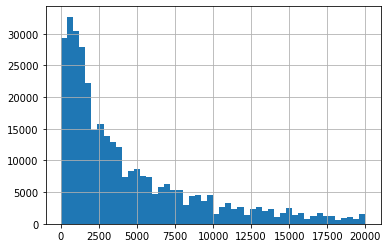

In [9]:
#распределение цен
df.price.hist(bins=50);

In [10]:
print('Кол-во выбросов:', len(outliers('price')))

Кол-во выбросов: 18180


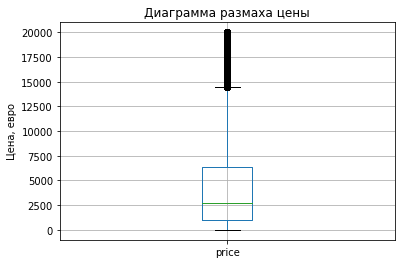

In [11]:
df.boxplot('price');
plt.title('Диаграмма размаха цены');
plt.ylabel('Цена, евро');

In [12]:
df = df.drop(outliers('price'))
print('Кол-во записей в датафрейме после удаления выбросов:', df.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 322817


Найдем слишком низкие цены. Пусть порог цены будет 200 евро, те объекты, что будут ниже этого порога - под удаление.  

In [13]:
print('Кол-во аномалий:', df.query('price <= 200').shape[0])

Кол-во аномалий: 18942


In [14]:
# Удаление объектов с аномально низкой стоимостью продажи
df = df[~(df.price <= 200)]
print('Кол-во записей в датафрейме после удаления аномалий:', df.shape[0])

Кол-во записей в датафрейме после удаления аномалий: 303875


Удалены аномалии и выбросы.

#### Year

Если год регистрации автомобиля больше, чем год создания анекты, то считаем это за аномалию.  
Также удалим выбросы с помощью диаграммы размаха.

In [15]:
# вытащим год из столбца с датой создания анекты
df['created_year'] = pd.to_datetime(df.created, format='%Y-%m-%d %H:%M:%S')
df['created_year'] = pd.DatetimeIndex(df['created_year']).year
df.head()

,price,vehicle_type,year,gearbox,power,model,km,fuel,brand,repaired,created,created_year
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,2016
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,2016
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,2016
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04 00:00:00,2016


In [16]:
print('Кол-во аномалий:', df.query('year > created_year').shape[0])

Кол-во аномалий: 12995


In [17]:
df = df[~(df.year > df.created_year)]
print('Кол-во записей в датафрейме после удаления аномалий:', df.shape[0])

Кол-во записей в датафрейме после удаления аномалий: 290880


Кол-во выбросов: 1354


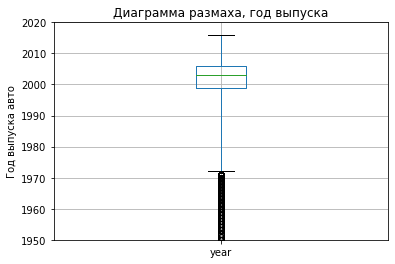

In [18]:
df.boxplot('year', whis=3.9);
plt.ylim(1950, 2020);
plt.title('Диаграмма размаха, год выпуска');
plt.ylabel('Год выпуска авто');
print('Кол-во выбросов:', len(outliers('year', q1=0.1, q3=0.9)))

In [19]:
df = df.drop(outliers('year', q1=0.1, q3=0.9))
print('Кол-во записей в датафрейме после удаления выбросов:', df.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 289526


Удалены аномалии и выбросы.

#### Power

Найдем выбросы в значениях мощности автомобиля. Также отбросим слишком низкие значения, начиная с 45.

Кол-во выбросов: 5340


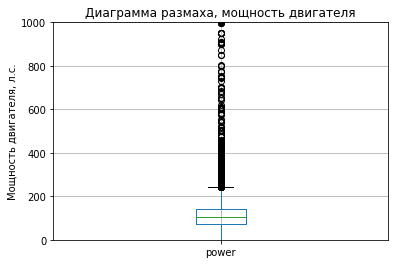

In [20]:
df.boxplot('power');
plt.ylim(0, 1000);
plt.title('Диаграмма размаха, мощность двигателя');
plt.ylabel('Мощность двигателя, л.с.');
print('Кол-во выбросов:', len(outliers('power')))

In [21]:
df = df.drop(outliers('power'))
print('Кол-во записей в датафрейме после удаления выбросов:', df.shape[0])

Кол-во записей в датафрейме после удаления выбросов: 284186


Найдем аномалии и удалим их.

In [22]:
print('Кол-во аномалий:', df.query('power < 45').shape[0])
df = df[~(df.power < 45)]
print('Кол-во записей в датафрейме после удаления аномалий:', df.shape[0])

Кол-во аномалий: 29558
Кол-во записей в датафрейме после удаления аномалий: 254628


Аномалии и выбросы удалены.  
Было пожертвовано большое количество материала для обучения моделей в угоду качеству.

#### Km

count    254628.000000
mean     130618.019228
std       34624.531965
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: km, dtype: float64

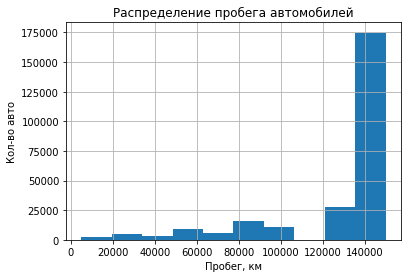

In [23]:
df.km.hist()
plt.title('Распределение пробега автомобилей')
plt.xlabel('Пробег, км')
plt.ylabel('Кол-во авто')

df.km.describe()

Кол-во выбросов: 33324


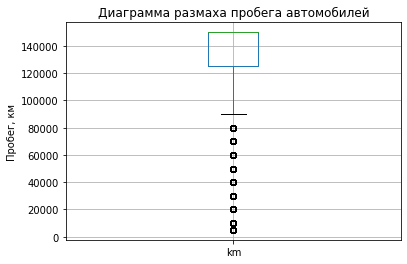

In [24]:
df.boxplot('km');
plt.title('Диаграмма размаха пробега автомобилей');
plt.ylabel('Пробег, км');

print('Кол-во выбросов:', len(outliers('km')))

Если удалить выбросы, то мы лишимся объектов с пробегом 80 тыс км и ниже. Тем более таких записей 30 тыс штук, поэтому оставим их и не будем удалять.

#### Вывод

На данном этапе избавились от записей с аномальными значениями или с выбросами.  
Было удалено 26 % объектов. Такое большое количество обусловлено тем, что данные были слишком "грязные". Теперь датафрейм приведен в порядок и с ним можно работать.

### Обработка пропущенных значений

Взглянем на пропуски в столбцах.

In [25]:
df.isna().sum()

price               0
vehicle_type     9532
year                0
gearbox          4570
power               0
model            9275
km                  0
fuel            13614
brand               0
repaired        37897
created             0
created_year        0
dtype: int64

#### Vehicle_type

In [26]:
print('Кол-во пропусков:', df[df.vehicle_type.isna()].shape[0])

Кол-во пропусков: 9532


In [27]:
print('Уникальные значения:', df.vehicle_type.unique())

Уникальные значения: ['suv' 'small' 'sedan' 'convertible' 'wagon' nan 'bus' 'coupe' 'other']


Кол-во авто по типам кузовов:

In [28]:
df.vehicle_type.value_counts()

sedan          70952
small          62765
wagon          51793
bus            23515
convertible    15316
coupe          11159
suv             7460
other           2136
Name: vehicle_type, dtype: int64

Заменим пропущенные значения на other.

In [29]:
df.vehicle_type.fillna(value='other', inplace=True)

print('Кол-во пропусков после исправления:', df[df.vehicle_type.isna()].shape[0])

Кол-во пропусков после исправления: 0


Пропущенные значения были заменены на заглушку other.

#### Gearbox

In [30]:
print('Кол-во пропусков:', df[df.gearbox.isna()].shape[0])

Кол-во пропусков: 4570


In [31]:
print('Уникальные значения:', df.gearbox.unique())

Уникальные значения: ['auto' 'manual' nan]


Пропущенные значения невозможно восстановить: автомобиль в рамках одной марки и модели может поставляться как с автоматической, так и с механической коробкой передач.  
Пропущенные значения заполним заглушкой 'unknown'.

In [32]:
df.gearbox.fillna(value='unknown', inplace=True)

print('Кол-во пропусков:', df[df.gearbox.isna()].shape[0])

Кол-во пропусков: 0


Пропуски были заменены на заглушку other.

#### Model

In [33]:
print('Кол-во пропусков:', df[df.model.isna()].shape[0])

Кол-во пропусков: 9275


Кол-во авто по моделям:

In [34]:
df.model.value_counts()

golf          21694
other         16726
3er           15234
polo           9596
corsa          8878
              ...  
serie_2           2
601               1
gl                1
serie_3           1
rangerover        1
Name: model, Length: 247, dtype: int64

Пропущенные значения заполним заглушкой 'other'.

In [35]:
df.model.fillna(value='other', inplace=True)

print('Кол-во пропусков:', df[df.model.isna()].shape[0])

Кол-во пропусков: 0


Пропуски были заменены на заглушку other.

#### Fuel

In [36]:
print('Кол-во пропусков:', df[df.fuel.isna()].shape[0])

Кол-во пропусков: 13614


Кол-во авто по типу используемого топлива:

In [37]:
df.fuel.value_counts()

petrol      163136
gasoline     73285
lpg           3912
cng            464
hybrid         147
other           43
electric        27
Name: fuel, dtype: int64

In [38]:
df.fuel.fillna(value='other', inplace=True)

print('Кол-во пропусков после исправления:', df[df.fuel.isna()].shape[0])

Кол-во пропусков после исправления: 0


Пропуски были заменены на заглушку other.

#### Repaired

In [39]:
print('Кол-во пропусков:', df[df.repaired.isna()].shape[0])

Кол-во пропусков: 37897


Кол-во авто по признаку ремонта:

In [40]:
df.repaired.value_counts(dropna=False)

no     191627
NaN     37897
yes     25104
Name: repaired, dtype: int64

In [41]:
df.repaired.fillna(value='unknown', inplace=True)
print('Кол-во пропусков после исправления:', df[df.repaired.isna()].shape[0])

Кол-во пропусков после исправления: 0


Пропуски заменены на заглушку unknown.

#### Вывод

Кол-во пропусков по столбцам:

In [42]:
df.isna().sum()

price           0
vehicle_type    0
year            0
gearbox         0
power           0
model           0
km              0
fuel            0
brand           0
repaired        0
created         0
created_year    0
dtype: int64

Все пропущенные значения были обработаны.

### Удаление столбцов

Теперь удалим оставшиеся неинформативные столбцы.

In [43]:
# удаление неинформативных столбцов
df.drop(labels=['created', 'created_year'], 
        axis=1, inplace=True)
df.head()

,price,vehicle_type,year,gearbox,power,model,km,fuel,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


Обновим индексы, т.к. после удаления объектов остались пропуски.

In [44]:
# переиндексирование датафрейма
df.reset_index(drop=True, inplace=True)
df.head()

,price,vehicle_type,year,gearbox,power,model,km,fuel,brand,repaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


### Изменение типа столбцов

Поменяем тип категориальных признаков с object на category. Это потребуется для корректной работы LightGBM.

In [45]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel', 'brand', 'repaired']
df[cat_features] = df[cat_features].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254628 entries, 0 to 254627
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         254628 non-null  int64   
 1   vehicle_type  254628 non-null  category
 2   year          254628 non-null  int64   
 3   gearbox       254628 non-null  category
 4   power         254628 non-null  int64   
 5   model         254628 non-null  category
 6   km            254628 non-null  int64   
 7   fuel          254628 non-null  category
 8   brand         254628 non-null  category
 9   repaired      254628 non-null  category
dtypes: category(6), int64(4)
memory usage: 9.5 MB


Взглянем на корреляцию численных признаков.

In [46]:
df.corr()

,price,year,power,km
price,1.000000,0.535035,0.444357,-0.347942
year,0.535035,1.000000,0.084184,-0.311886
power,0.444357,0.084184,1.000000,0.165990
km,-0.347942,-0.311886,0.165990,1.000000


## Подготовка признаков для моделей

Для линейной регрессии и дерева решений признаки нужно закодировать, разделить на выборки и стандартизировать.  

Для модели градиентного бустинга требуется только разделить и стандартизировать признаки, т.к. алгоритм работает с категориальными признаками напрямую. Однако, процесс кодирования в модели будет занимать какое-то время, что увеличивает длительность обучения, поэтому закодируем категориальные признаки перед обучением модели.

### Деление на выборки

Разделим датафрейм на обучающую и тестовую выборки в отношении 3:1.

In [47]:
target = df.price
features = df.drop('price', axis=1)

state=12345

target_train, target_test, features_train, features_test = \
    train_test_split(target, features, test_size=0.25, random_state=state)

In [48]:
target_train.shape, target_test.shape, features_train.shape, features_test.shape

((190971,), (63657,), (190971, 9), (63657, 9))

### Кодирование признаков

In [49]:
# категориальные признаки
cat_features = df.select_dtypes('category').columns

# функция прямого кодирования без дамми-ловушки
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# обучение и преобразование категориальных признаков, получаем массив
features_train_ohe = ohe.fit_transform(features_train[cat_features])
features_test_ohe = ohe.transform(features_test[cat_features])

# добавление в признаки закодированных столбцов
features_train.loc[:, ohe.get_feature_names()] = features_train_ohe
features_test.loc[:, ohe.get_feature_names()] = features_test_ohe

# удаление из признаков первоначальных категориальных столбцов
features_train.drop(columns=cat_features, inplace=True)
features_test.drop(columns=cat_features, inplace=True)

In [50]:
del features_train_ohe, features_test_ohe, ohe
display(features_train.head(), features_test.head())

,year,power,km,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_unknown,x5_yes
65739,1996,147,150000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8310,1999,116,100000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
188112,1992,140,150000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
90169,2007,130,90000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
210600,2003,136,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


,year,power,km,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_unknown,x5_yes
28837,2005,131,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
213028,2003,150,150000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
164383,2002,150,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
89009,2002,101,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
93353,2008,160,125000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Стандартизация признаков

In [51]:
# названия признаков с числовыми данными
numeric_features = ['year', 'power', 'km']
scaler = StandardScaler()

# копирование призанков
features_train_scal = features_train.copy()
features_test_scal = features_test.copy()

# обучение и трансформация
features_train_scal[numeric_features] = scaler.fit_transform(features_train[numeric_features])
features_test_scal[numeric_features] = scaler.transform(features_test[numeric_features])

## обучение и трансформация
#features_train[numeric_features] = scaler.fit_transform(features_train[numeric_features])
#features_test[numeric_features] = scaler.transform(features_test[numeric_features])

# проверка результатов преобразования
display(features_train_scal.head(), features_test_scal.head())

# удаление переменных 
del scaler, numeric_features

,year,power,km,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_unknown,x5_yes
65739,-1.132399,0.755987,0.560209,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8310,-0.623562,0.036882,-0.880887,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
188112,-1.810848,0.593608,0.560209,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
90169,0.733336,0.361639,-1.169106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
210600,0.054887,0.500821,0.560209,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


,year,power,km,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_unknown,x5_yes
28837,0.394112,0.384836,0.560209,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
213028,0.054887,0.825577,0.560209,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
164383,-0.114725,0.825577,0.560209,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
89009,-0.114725,-0.311071,0.560209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
93353,0.902949,1.057547,-0.160339,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Обучение моделей

Обучим 3 модели: линейную регрессию, дерево решений и LightGBM.  
Для оценки качества предсказания будем использовать RMSE.

### Дамми-модель

Для проверки моделей на адекватность создадим константную модель.

In [52]:
# обучение модели
model = LinearRegression()
model.fit(features_train, target_train)

# предсказание модели
predictions = pd.Series(target_train.mean(), index=target_train.index)
print('RMSE константной модели:', mean_squared_error(target_train, predictions, squared=False))

RMSE константной модели: 3472.232040918993


### Линейная регрессия

Посчитаем метрику для линейной регрессии через кросс-валидацию.

In [53]:
# с масштабированием признаков
lr_scal = cross_validate(LinearRegression(), 
                         X=features_train_scal, 
                         y=target_train,
                         scoring='neg_root_mean_squared_error',
                         cv=10)

# без масштабирования признаков
lr = cross_validate(LinearRegression(), 
                    X=features_train, 
                    y=target_train,
                    scoring='neg_root_mean_squared_error',
                    cv=10)

In [54]:
print('RMSE линейной регрессии с масштабированием:', abs(lr_scal['test_score'].mean()))
print('RMSE линейной регрессии без масштабирования:', abs(lr['test_score'].mean()))

RMSE линейной регрессии с масштабированием: 3358331393108.1743
RMSE линейной регрессии без масштабирования: 1960.1187999809226


Линейная регрессия показывает необычно большое значение для масштабированных признаков. Откажемся от масштабирования.

In [55]:
print('Время обучения:', lr['fit_time'].mean())
print('Время предсказания:', lr['score_time'].mean())
print('RMSE линейной регрессии:', abs(lr['test_score'].mean()))

Время обучения: 3.1201751470565795
Время предсказания: 0.02254376411437988
RMSE линейной регрессии: 1960.1187999809226


### Дерево решений

Подберем гиперпараметры для модели с помощью GridSearchCV. Перебирать будем только глубину дерева.

In [56]:
%%time

params = {'max_depth': list(range(20, 46, 5)),
          'min_samples_split': list(range(2, 22, 5)),
          'min_samples_leaf': [4, 6]
         }

dtr = GridSearchCV(DecisionTreeRegressor(random_state=state),
                    params,
                    scoring='neg_root_mean_squared_error',
                    cv=3
                    )

dtr.fit(features_train_scal, target_train)

CPU times: total: 8min 9s
Wall time: 8min 14s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [20, 25, 30, 35, 40, 45],
                         'min_samples_leaf': [4, 6],
                         'min_samples_split': [2, 7, 12, 17]},
             scoring='neg_root_mean_squared_error')

Запишем в переменную модель, показавшую наилучший результат.

In [57]:
best_dtr_model = dtr.best_estimator_

In [58]:
results = pd.DataFrame(dtr.cv_results_)
best_result_dtr = results[results.rank_test_score == 1][['mean_fit_time', 'mean_score_time', 'mean_test_score']].values[0]

print('Дерево решений')
print('Время обучения, с:', best_result_dtr[0])
print('Время предсказания, с:', best_result_dtr[1])
print('RMSE:', abs(best_result_dtr[2]))

Дерево решений
Время обучения, с: 3.507319370905558
Время предсказания, с: 0.06886959075927734
RMSE: 1410.0562245868648


### LightGBM

Подберем гиперпараметры для модели с помощью RandomizedSearchCV. Перебирать будем глубину дерева, скорость обучения и количество деревьев.

In [59]:
%%time

params = {'max_depth': list(range(20, 201, 10)),
         'learning_rate': list(np.arange(0.1, 1.1, 0.1)),
         'n_estimators': list(range(20, 201, 10)),
         #'boosting_type': ['gbdt', 'dart', 'rf']
          'num_leaves': list(range(20, 101, 10)),
          'reg_alpha': list(range(1, 28, 1)),
          'reg_lambda': list(range(1, 28, 1))
         }

lgbm = RandomizedSearchCV(LGBMRegressor(random_state=state), 
                          params,
                          scoring='neg_root_mean_squared_error',
                          random_state=state,
                          cv=3,
                          n_iter=50
                         )


lgbm.fit(features_train_scal, target_train)

CPU times: total: 10min 57s
Wall time: 2min 49s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345), n_iter=50,
                   param_distributions={'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5, 0.6,
                                                          0.7000000000000001,
                                                          0.8, 0.9, 1.0],
                                        'max_depth': [20, 30, 40, 50, 60, 70,
                                                      80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200],
                                        'n_estimators': [20, 30, 40, 50, 60, 70,
                                                         80, 90, 100, 110, 120,
                                                         130, 140, 150, 160,
     

Запишем в переменную лучшую модель.

In [60]:
best_lgbm_model = lgbm.best_estimator_

In [61]:
results = pd.DataFrame(lgbm.cv_results_)
best_result_lgbm = results[results.rank_test_score == 1][['mean_fit_time', 'mean_score_time', 'mean_test_score']].values[0]

print('LightGBM')
print('Время обучения, с:', best_result_lgbm[0])
print('Время предсказания, с:', best_result_lgbm[1])
print('RMSE:', abs(best_result_lgbm[2]))

LightGBM
Время обучения, с: 1.4961271286010742
Время предсказания, с: 0.3715088367462158
RMSE: 1248.8230103169255


## Анализ моделей

Соберем в таблицу значения из предудщего этапа.

In [62]:
final_table = pd.DataFrame(data=[[lr['fit_time'].mean(), best_result_dtr[0], best_result_lgbm[0]], 
                                 [lr['score_time'].mean(), best_result_dtr[1], best_result_lgbm[1]], 
                                 [abs(lr['test_score'].mean()), abs(best_result_dtr[2]), abs(best_result_lgbm[2])]],
             columns=['Линейная регрессия', 'Дерево решений','LightGBM'],
             index=['Время обучения, с', 'Время предсказания, с', 'RMSE']).T
final_table

,"Время обучения, с","Время предсказания, с",RMSE
Линейная регрессия,3.120175,0.022544,1960.118800
Дерево решений,3.507319,0.068870,1410.056225
LightGBM,1.496127,0.371509,1248.823010


Построим графики для наглядности.

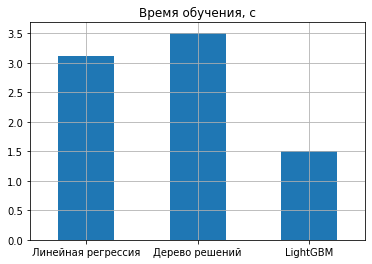

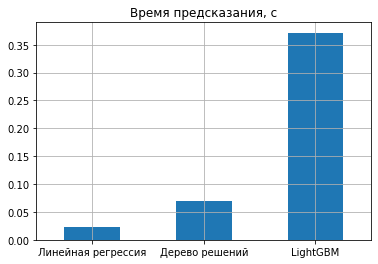

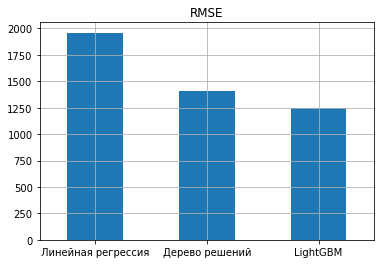

In [63]:
final_table.plot.bar(y='Время обучения, с',
                     grid=True,
                     title='Время обучения, с',
                     legend=False
                     );
plt.xticks(rotation = 0);
final_table.plot.bar(y='Время предсказания, с',
                     grid=True,
                     title='Время предсказания, с',
                     legend=False
                     );
plt.xticks(rotation = 0);
final_table.plot.bar(y='RMSE',
                     grid=True,
                     title='RMSE',
                     legend=False
                     );
plt.xticks(rotation = 0);

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.  

Наилучшее качество предсказания показала LightGBM, но ее время предсказания - третье, зато по времени обучения - первая.

Т. к. заказчику важны все три критерия, то оптимальной моделью для него будет LightGBM. Протестируем её.

In [64]:
%%time
best_lgbm_model.fit(features_train_scal, target_train)

CPU times: total: 5.7 s
Wall time: 1.34 s


LGBMRegressor(learning_rate=0.2, max_depth=20, n_estimators=170, num_leaves=100,
              random_state=12345, reg_alpha=10, reg_lambda=27)

In [65]:
%%time 
predictions = best_lgbm_model.predict(features_test_scal)

CPU times: total: 1.84 s
Wall time: 399 ms


In [66]:
print('RMSE:', mean_squared_error(target_test, predictions, squared=False))

RMSE: 1234.3302984426823


Модель LightGBM следующие результаты после тестирования:
- Время обучения, с: 1.34;
- Время предсказания, с: 0.399;
- RMSE: 1234.

## Вывод

Данный проект состоял из нескольких этапов.  

На первом этапе были подготовлены данные. Были удалены полные дубли, аномалии и выбросы; обработаны пропущенные значения, подготовлены признаки для моделей.  

Затем были подобраны гиперпараметры и обучены три модели: линейная регрессия, дерево решений и LightGBM - модель градиентного бустинга.

Последний этап включал в себя анализ результатов обученных моделей.  

Было выяснено, что оптимальная модель для заказчика - LightGBM, показавшая RMSE=1234, со следующими гиперпараметрами: 

- learning_rate=0.2, 
- max_depth=20, 
- n_estimators=170, 
- num_leaves=100, 
- reg_alpha=10, 
- reg_lambda=27.